In [1]:
import numpy as np

from matrix_generator import generate_matrix
import subprocess
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
matrix_sizes = [0x200, 0x400, 0x600, 0x800, 0x1000, 0x1200, 0x1400, 0x1600,
                0x1800, 0x2000]
patterns = ["checkerboard", "blockdiagonal", "random"]

In [20]:
#define test matrix sizes

matrix_files = []

# generate matrix input sizes
for matrix_size in matrix_sizes:
    for pattern in patterns:
        matrix_name = f"tests/MatrixA_{matrix_size}_{pattern}.mat"
        matrix_files.append((matrix_name, matrix_size, pattern))
        # generate_matrix(output=matrix_name,
        #                 num_cols=matrix_size,
        #                 num_rows=matrix_size,
        #                 sparsity=0.0,
        #                 dtype='float16',
        #                 heatmap=False,
        #                 pattern=pattern,
        #                 blocksize=16)
        print("Created " + matrix_name)

Created tests/MatrixA_512_checkerboard.mat
Created tests/MatrixA_512_blockdiagonal.mat
Created tests/MatrixA_512_random.mat
Created tests/MatrixA_1024_checkerboard.mat
Created tests/MatrixA_1024_blockdiagonal.mat
Created tests/MatrixA_1024_random.mat
Created tests/MatrixA_1536_checkerboard.mat
Created tests/MatrixA_1536_blockdiagonal.mat
Created tests/MatrixA_1536_random.mat
Created tests/MatrixA_2048_checkerboard.mat
Created tests/MatrixA_2048_blockdiagonal.mat
Created tests/MatrixA_2048_random.mat
Created tests/MatrixA_4096_checkerboard.mat
Created tests/MatrixA_4096_blockdiagonal.mat
Created tests/MatrixA_4096_random.mat
Created tests/MatrixA_4608_checkerboard.mat
Created tests/MatrixA_4608_blockdiagonal.mat
Created tests/MatrixA_4608_random.mat
Created tests/MatrixA_5120_checkerboard.mat
Created tests/MatrixA_5120_blockdiagonal.mat
Created tests/MatrixA_5120_random.mat
Created tests/MatrixA_5632_checkerboard.mat
Created tests/MatrixA_5632_blockdiagonal.mat
Created tests/MatrixA_563

In [41]:
matrix_files

[('tests/MatrixA_512_checkerboard.mat', 512, 'checkerboard'),
 ('tests/MatrixA_512_blockdiagonal.mat', 512, 'blockdiagonal'),
 ('tests/MatrixA_512_random.mat', 512, 'random'),
 ('tests/MatrixA_1024_checkerboard.mat', 1024, 'checkerboard'),
 ('tests/MatrixA_1024_blockdiagonal.mat', 1024, 'blockdiagonal'),
 ('tests/MatrixA_1024_random.mat', 1024, 'random'),
 ('tests/MatrixA_1536_checkerboard.mat', 1536, 'checkerboard'),
 ('tests/MatrixA_1536_blockdiagonal.mat', 1536, 'blockdiagonal'),
 ('tests/MatrixA_1536_random.mat', 1536, 'random'),
 ('tests/MatrixA_2048_checkerboard.mat', 2048, 'checkerboard'),
 ('tests/MatrixA_2048_blockdiagonal.mat', 2048, 'blockdiagonal'),
 ('tests/MatrixA_2048_random.mat', 2048, 'random'),
 ('tests/MatrixA_4096_checkerboard.mat', 4096, 'checkerboard'),
 ('tests/MatrixA_4096_blockdiagonal.mat', 4096, 'blockdiagonal'),
 ('tests/MatrixA_4096_random.mat', 4096, 'random'),
 ('tests/MatrixA_4608_checkerboard.mat', 4608, 'checkerboard'),
 ('tests/MatrixA_4608_blockdiago

In [ ]:
# test the code
for i in range(len(matrix_files)-9, len(matrix_files), 3):
    for run in range(30):
        print(f"Run {run}")
        print("Running " + matrix_files[i][0])
        result = subprocess.run(["./cmake-build-debug/matrix_multiplication",
                                 matrix_files[i][0], matrix_files[i+2][0]], stdout=subprocess.PIPE)
        print("Done running " + matrix_files[i][0])
        with open(f"tests/MatrixC_{matrix_files[i][1]}_{matrix_files[i][2]}_run{run}.res", "w") as f:
            f.write(result.stdout.decode('utf-8'))

        # print("Running " + matrix_files[i+1][0])
        # result = subprocess.run(["./cmake-build-debug/matrix_multiplication",
        #                          matrix_files[i+1][0], matrix_files[i+2][0]], stdout=subprocess.PIPE)
        # print("Done running " + matrix_files[i+1][0])
        # with (open(f"tests/MatrixC_{matrix_files[i+1][1]}_{matrix_files[i+1][2]}_run{run}.res", "w")
        #       as f):
        #     f.write(result.stdout.decode('utf-8'))

Run 0
Running tests/MatrixA_5632_checkerboard.mat


In [60]:
test_results = [str(p) for p in Path('tests/').rglob("MatrixC*")]

data = {'run':[], 'time':[], 'size':[], 'pattern':[], 'sparsity':[],
        'algorithm': [], 'gflops': [], 'rel_error': []}

for file in test_results:
    pattern = r'tests/MatrixC_(\d+)_([^_]+)_(\d+\.\d+)_(\d+)\.mat'
    match = re.match(pattern, file)

    if not match:
        print(f"no match for {file}")
        break

    matrix_size = int(match.group(1))
    matrix_pattern = match.group(2)
    sparsity = float(match.group(3))
    run_number = int(match.group(4))

    with open(file) as f:
        lines = f.readlines()

    for line in range(3, len(lines), 5):
        if lines[line].strip().startswith('CUDA'):
            line += 1
        algo = lines[line].split("time")[0].strip()
        time = float(lines[line].split(":")[1].strip())
        rel_error = float(lines[line+3].split(":")[1].strip())
        #(2 × N³ - N²) / (time_in_ms × 10⁶)

        if time != 0:
            gflops = (2.0 * matrix_size ** 3) / (time * 10 ** 6)
        else:
            gflops = -1

        data['run'].append(run_number)
        data['time'].append(time)
        data['size'].append(matrix_size)
        data['pattern'].append(matrix_pattern)

        data['sparsity'].append(sparsity)
        data['algorithm'].append(algo)
        data['gflops'].append(gflops)
        data['rel_error'].append(rel_error)

df = pd.DataFrame(data)
df.loc[df['algorithm'] == 'Dense on GPU', 'rel_error'] = 0.0
df.loc[df['gflops'] == -1, 'gflops'] = np.nan
df[df['algorithm'] == 'Dense on GPU'].head()
df.to_json('results.json')
df.to_csv('results.csv')
#df.to_excel('results.xlsx')

In [2]:
df = pd.read_csv('results.csv')
df.loc[df['algorithm'] == 'Dense on GPU Coalescence', 'rel_error'] = 0.0
df.head()

,Unnamed: 0,run,time,size,pattern,sparsity,algorithm,gflops,rel_error
0,0,29,465.802582,5376,blockrandom,0.7,Dense on GPU Coalescence,667.122955,0.000000
1,1,29,248.047943,5376,blockrandom,0.7,Dense WMMA,1252.772311,0.101347
2,2,29,196.904953,5376,blockrandom,0.7,SpMM 1 Co,1578.160376,0.000000
3,3,29,17.949921,5376,blockrandom,0.7,SpMM with Tensors,17311.919911,0.101347
4,4,29,47.047585,5376,blockrandom,0.7,cuBLAS GeMM,6604.963778,0.101347


In [3]:
algorithms = df['algorithm'].unique().tolist()
sparsities = df['sparsity'].unique().tolist()
matrix_sizes = df['size'].unique().tolist()
sparsities

[0.7, 0.8, 0.4, 0.9, 0.6, 0.5, 0.3]

In [101]:
avg_datas = list()

for algorithm in algorithms:
    for size in matrix_sizes:
        for sparsity in sparsities:
            group_df = df[(df['algorithm'] == algorithm) & (df['size'] == size) &
                          (df['sparsity'] == sparsity)]
            avg_dat = {'run': 'avg',
                       'time_mean': group_df['time'].mean(),
                       'time_med': group_df['time'].median(),
                       'time_min': group_df['time'].min(),
                       'time_max': group_df['time'].max(),
                       'time_var': group_df['time'].var(),
                       'size': size,
                       'pattern': group_df['pattern'].iloc[0],
                       'sparsity': group_df['sparsity'].iloc[0],
                       'algorithm': algorithm,
                       'gflops_mean': group_df['gflops'].mean(),
                       'gflops_med': group_df['gflops'].median(),
                       'gflops_min': group_df['gflops'].min(),
                       'gflops_max': group_df['gflops'].max(),
                       'gflops_var': group_df['gflops'].var(),
                       'rel_error_mean': group_df['rel_error'].mean(),
                       'rel_error_med': group_df['rel_error'].median(),
                       'rel_error_min': group_df['rel_error'].min(),
                       'rel_error_max': group_df['rel_error'].max(),
                       'rel_error_var': group_df['rel_error'].var(),
                       }
            avg_datas.append(avg_dat)

grouped_df = pd.DataFrame(avg_datas)
grouped_df.to_csv('avg_results.csv')
grouped_df.head()

,run,time_mean,time_med,time_min,time_max,time_var,size,pattern,sparsity,algorithm,gflops_mean,gflops_med,gflops_min,gflops_max,gflops_var,rel_error_mean,rel_error_med,rel_error_min,rel_error_max,rel_error_var
0,avg,433.853244,432.482819,428.109833,465.802582,48.593393,5376,blockrandom,0.7,Dense on GPU Coalescence,716.420421,718.520143,667.122955,725.859513,119.819729,0.0,0.0,0.0,0.0,0.0
1,avg,432.817943,431.055359,426.823669,478.193817,87.040484,5376,blockrandom,0.8,Dense on GPU Coalescence,718.260735,720.899652,649.836078,728.046773,203.335476,0.0,0.0,0.0,0.0,0.0
2,avg,435.081891,431.737915,429.057037,462.887085,80.879560,5376,blockrandom,0.4,Dense on GPU Coalescence,714.511300,719.759798,671.324832,724.257075,201.319674,0.0,0.0,0.0,0.0,0.0
3,avg,433.297215,432.337311,427.137024,464.465912,40.778795,5376,blockrandom,0.9,Dense on GPU Coalescence,717.312058,718.761939,669.042844,727.512665,100.044128,0.0,0.0,0.0,0.0,0.0
4,avg,433.653213,431.726272,428.161011,467.561523,49.913783,5376,blockrandom,0.6,Dense on GPU Coalescence,716.754047,719.779244,664.613274,725.772751,121.010182,0.0,0.0,0.0,0.0,0.0


In [4]:
grouped_df = pd.read_csv('avg_results.csv')
algorithms = grouped_df['algorithm'].unique().tolist()
sparsities = grouped_df['sparsity'].unique().tolist()
matrix_sizes = grouped_df['size'].unique().tolist()

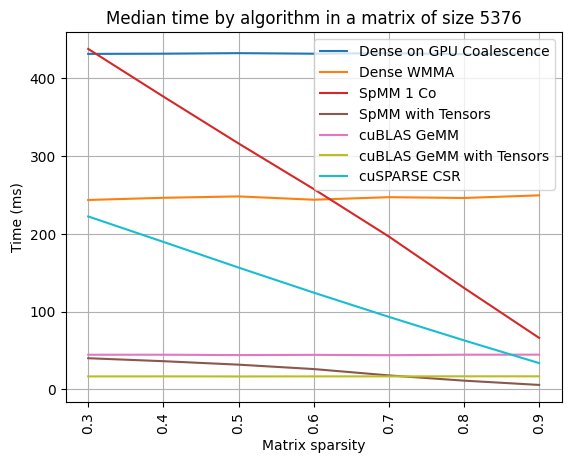

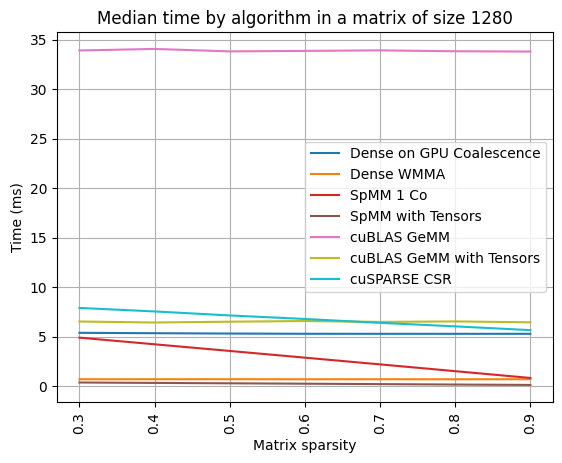

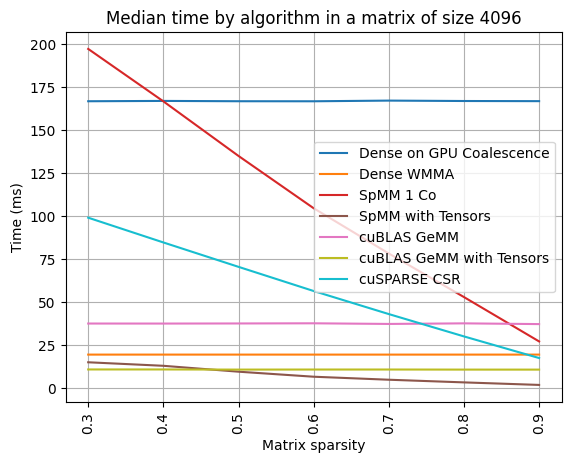

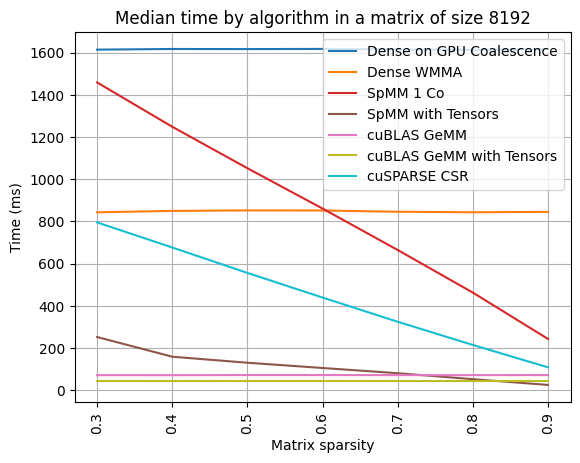

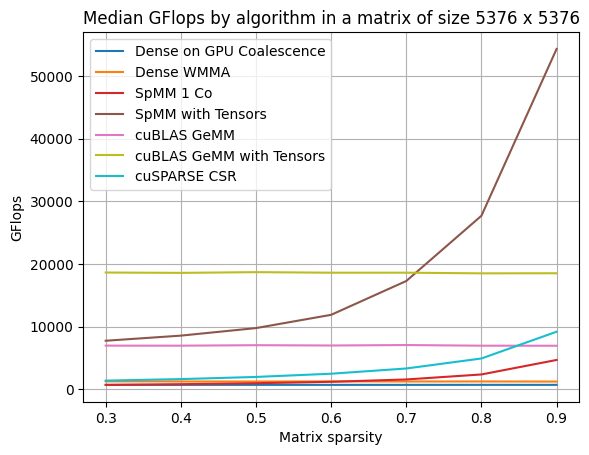

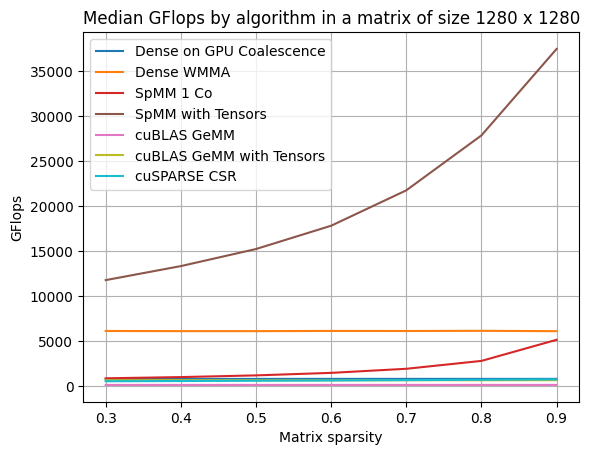

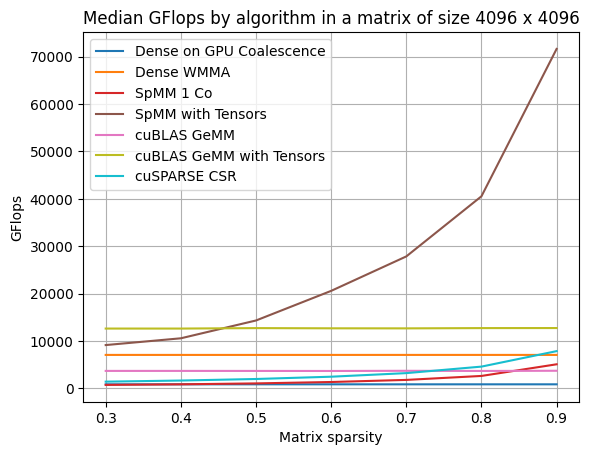

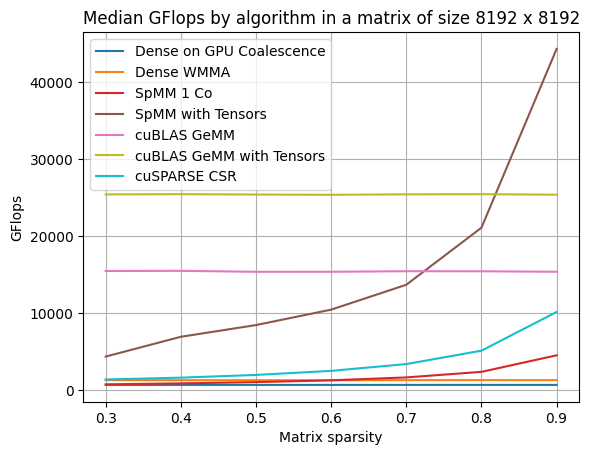

In [7]:
colors = plt.cm.tab10(np.linspace(0, 1, len(algorithms)))

for size in matrix_sizes:
    for i, algo in enumerate(algorithms):
        algo_df = grouped_df[(grouped_df['algorithm'] == algo) & (grouped_df['size'] == size)].sort_values('sparsity', ascending=True)
        plt.plot(algo_df['sparsity'], algo_df['time_med'], color=colors[i],
             label=algo)
    plt.xticks(grouped_df['sparsity'].unique().tolist(), rotation=90)
    plt.xlabel('Matrix sparsity')
    plt.ylabel('Time (ms)')
    plt.legend()
    plt.title('Median time by algorithm in a matrix of size ' + str(size))
    plt.grid()
    plt.show()

for size in matrix_sizes:
    for i, algo in enumerate(algorithms):
        algo_df = grouped_df[(grouped_df['algorithm'] == algo) & (grouped_df['size'] == size)].sort_values('sparsity', ascending=True)
        plt.plot(algo_df['sparsity'], algo_df['gflops_med'], color=colors[i],
             label=algo)
    plt.xticks(grouped_df['sparsity'].unique().tolist(), rotation=0)
    plt.xlabel('Matrix sparsity')
    plt.ylabel('GFlops')
    plt.legend()
    plt.title(f'Median GFlops by algorithm in a matrix of size {str(size)} x {str(size)}')
    plt.grid()
    plt.show()

In [8]:
grouped_df.head()

,Unnamed: 0,run,time_mean,time_med,time_min,time_max,time_var,size,pattern,sparsity,...,gflops_mean,gflops_med,gflops_min,gflops_max,gflops_var,rel_error_mean,rel_error_med,rel_error_min,rel_error_max,rel_error_var
0,0,avg,433.853244,432.482819,428.109833,465.802582,48.593393,5376,blockrandom,0.7,...,716.420421,718.520143,667.122955,725.859513,119.819729,0.0,0.0,0.0,0.0,0.0
1,1,avg,432.817943,431.055359,426.823669,478.193817,87.040484,5376,blockrandom,0.8,...,718.260735,720.899652,649.836078,728.046773,203.335476,0.0,0.0,0.0,0.0,0.0
2,2,avg,435.081891,431.737915,429.057037,462.887085,80.879560,5376,blockrandom,0.4,...,714.511300,719.759798,671.324832,724.257075,201.319674,0.0,0.0,0.0,0.0,0.0
3,3,avg,433.297215,432.337311,427.137024,464.465912,40.778795,5376,blockrandom,0.9,...,717.312058,718.761939,669.042844,727.512665,100.044128,0.0,0.0,0.0,0.0,0.0
4,4,avg,433.653213,431.726272,428.161011,467.561523,49.913783,5376,blockrandom,0.6,...,716.754047,719.779244,664.613274,725.772751,121.010182,0.0,0.0,0.0,0.0,0.0


In [28]:
grouped_df['nums_considered'] = (grouped_df['size'] ** 2 *
                                np.where((grouped_df['algorithm'].str.startswith('SpMM') |
                                         grouped_df['algorithm'].str.contains('CSR')),
                                        grouped_df['sparsity'], 1.0))
grouped_df.head()

,Unnamed: 0,run,time_mean,time_med,time_min,time_max,time_var,size,pattern,sparsity,...,gflops_med,gflops_min,gflops_max,gflops_var,rel_error_mean,rel_error_med,rel_error_min,rel_error_max,rel_error_var,nums_considered
0,0,avg,433.853244,432.482819,428.109833,465.802582,48.593393,5376,blockrandom,0.7,...,718.520143,667.122955,725.859513,119.819729,0.0,0.0,0.0,0.0,0.0,28901376.0
1,1,avg,432.817943,431.055359,426.823669,478.193817,87.040484,5376,blockrandom,0.8,...,720.899652,649.836078,728.046773,203.335476,0.0,0.0,0.0,0.0,0.0,28901376.0
2,2,avg,435.081891,431.737915,429.057037,462.887085,80.879560,5376,blockrandom,0.4,...,719.759798,671.324832,724.257075,201.319674,0.0,0.0,0.0,0.0,0.0,28901376.0
3,3,avg,433.297215,432.337311,427.137024,464.465912,40.778795,5376,blockrandom,0.9,...,718.761939,669.042844,727.512665,100.044128,0.0,0.0,0.0,0.0,0.0,28901376.0
4,4,avg,433.653213,431.726272,428.161011,467.561523,49.913783,5376,blockrandom,0.6,...,719.779244,664.613274,725.772751,121.010182,0.0,0.0,0.0,0.0,0.0,28901376.0


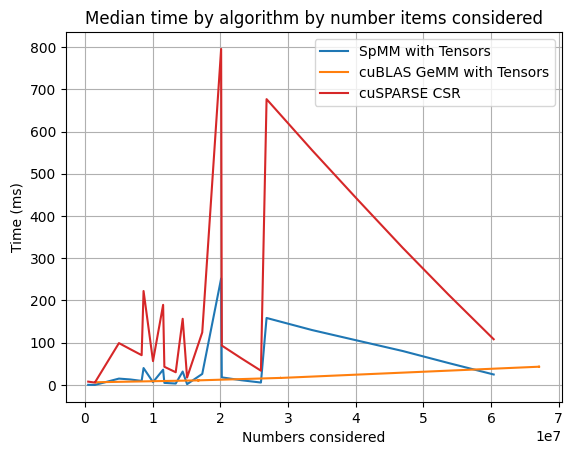

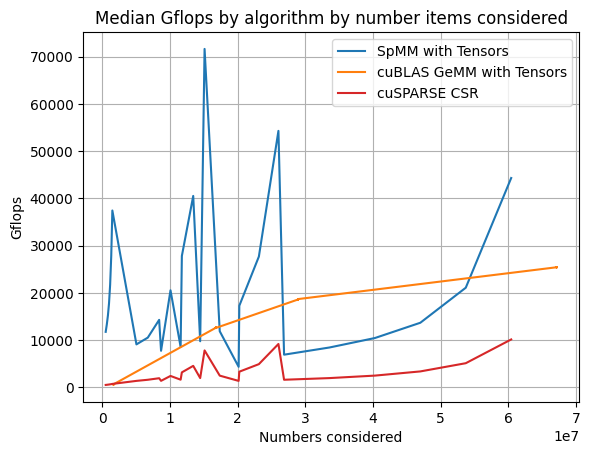

In [29]:
colors = plt.cm.tab10(np.linspace(0, 1, len(algorithms)))

for i, algo in enumerate(['SpMM with Tensors', 'cuBLAS GeMM with Tensors',
                          'cuSPARSE CSR']):
    algo_df = (grouped_df[(grouped_df['algorithm'] == algo)].sort_values
               ('nums_considered', ascending=True))
    plt.plot(algo_df['nums_considered'], algo_df['time_med'], color=colors[i],
         label=algo)
#plt.xticks(grouped_df['nums_considered'].unique().tolist(), rotation=90)
plt.xlabel('Numbers considered')
plt.ylabel('Time (ms)')
plt.legend()
plt.title('Median time by algorithm by number items considered')
plt.grid()
plt.show()

for i, algo in enumerate(['SpMM with Tensors', 'cuBLAS GeMM with Tensors',
                          'cuSPARSE CSR']):
    algo_df = (grouped_df[(grouped_df['algorithm'] == algo)].sort_values
               ('nums_considered', ascending=True))
    plt.plot(algo_df['nums_considered'], algo_df['gflops_med'], color=colors[i],
         label=algo)
#plt.xticks(grouped_df['nums_considered'].unique().tolist(), rotation=90)
plt.xlabel('Numbers considered')
plt.ylabel('Gflops')
plt.legend()
plt.title('Median Gflops by algorithm by number items considered')
plt.grid()
plt.show()